# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra (igual creamos un test para pruebas internas)

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,accuracy_score,recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve 

## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

In [3]:
df_cleaned = df_orig.copy()
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2,random_state=322)

In [4]:
rfe = RFECV(RandomForestClassifier(n_estimators=2000),scoring="recall",min_features_to_select=5,cv=10,verbose=1,n_jobs=-1)
rfe = rfe.fit(feat_train,targ_train)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


In [5]:
for feat in zip(feat_train.columns,rfe.support_):
    print(feat)

('age', True)
('anaemia', False)
('creatinine_phosphokinase', True)
('diabetes', False)
('ejection_fraction', True)
('high_blood_pressure', False)
('platelets', False)
('serum_creatinine', True)
('serum_sodium', False)
('sex', False)
('smoking', False)
('time', True)


## Transformaciones necesarias al df

In [6]:
#df_orig["cant_path"] = df_orig["anaemia"]+df_orig["high_blood_pressure"]+df_orig["diabetes"]
#df_cleaned = df_orig.copy()
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

In [7]:
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [8]:
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2,random_state=69)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [9]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE().fit_resample(feat_train, targ_train)

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [10]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---
---
---

# LOGISTIC REGRESSION

### La teoría indica que el Logistic Regressor no tiene hyperparametros q valgan la pena tunear mas allá del penalty o un poco el "C".

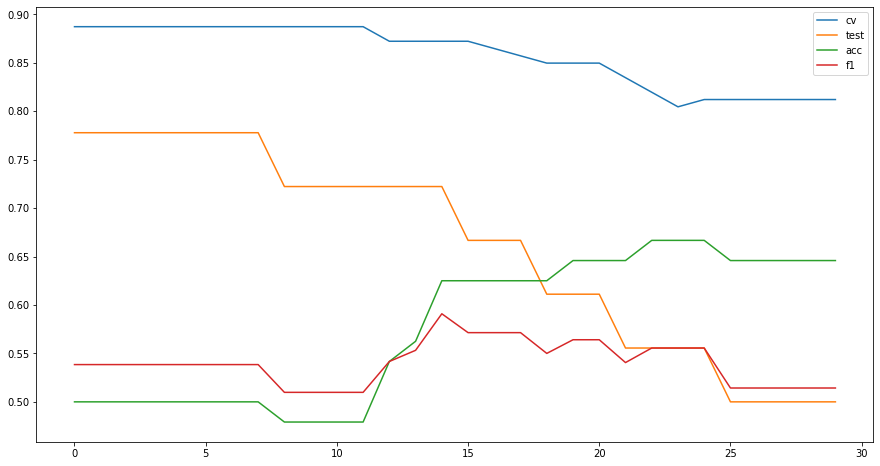

In [56]:
lr_scoring = []
lr_scoring_t = []
lr_acc = []
lr_f1 = []
for g in np.logspace(-5,-1,30):
    lr_model = Pipeline([["poly",PolynomialFeatures(degree=2)],["regressor",LogisticRegression(fit_intercept=False, dual=False, max_iter=50000, C=g)]])
    lr_model.fit(feat_train,targ_train)
    lr_scoring.append(recall_score(targ_train,cross_val_predict(lr_model,feat_train,targ_train,cv=10)))
    lr_scoring_t.append(recall_score(targ_test,lr_model.predict(scaler.transform(feat_test))))
    lr_acc.append(accuracy_score(targ_test,lr_model.predict(scaler.transform(feat_test))))
    lr_f1.append(f1_score(targ_test,lr_model.predict(scaler.transform(feat_test))))
plt.figure(figsize=(15,8))

plt.plot(lr_scoring,label="cv")
plt.plot(lr_scoring_t,label="test")
plt.plot(lr_acc,label="acc")
plt.plot(lr_f1,label="f1")
plt.legend()

Test: 0.778


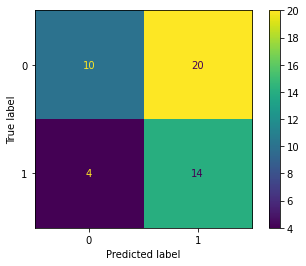

In [37]:
lr_predicted_t = lr_model.predict(scaler.transform(feat_test))
cm = confusion_matrix(targ_test, lr_predicted_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
rf_scoring_t = recall_score(targ_test,lr_predicted_t)
print("Test: {:.3f}".format(rf_scoring_t))

---